# Emotional numbing in PTSD a look into a paradox

PTSD is famously known among other for hyper arousal, anger, nightmare, problems with emotion regulation and emotional numbing. </br>
While most symptoms point to over expression of emotions, emotional numbing states that there is low emotionality.

In a not realy direct way, here, we will continue to explore the idea we proposed in the SIA paper.</br>
Mainly, reduced response to low valance/arousing stimuli and high response to higher valance stimuli.

In this experiment we will explore this by asking people with or without diagnosis of PTSD to rate pictures from known datasets (IAPS/NAPS).</br> 
Using the dataset reported valence rating as the X axis and participants rating as the y-axis, we will fit a 5 parameter logistic regression to the curve of participants and compare the parameters between the groups.

The formula we will use for the 5PL regression:

y = d + (a-d)/(1+(x/c)^b)^g

a theoretical response at min</br>
b slope factor</br>
c mid range </br>
d theoretical response at max</br>
g asymmetrical factor</br>

Our main hypothesis is regadind b.</br>
Lower values of b point to a linear relation.</br>
Our main hypothesis is a larger b in the PTSD group compared with control.</br>
Secondary hypothesis include:</br>
1. b will be modulated by emotional numbing (PCL5)</br>
2. d will be modulated by depression/anhedonia score (PCL5/BDI)

In [2]:
import pandas as pd
import numpy as np
import numpyro

import pymc as pm
import pymc.sampling_jax as jx
import arviz as az
import jax
numpyro.set_host_device_count(4)

import matplotlib.pyplot as ply
import seaborn as sns

## Data generation

If we assume that participants with or without PTSD diagnosis both respond using a 5PL model,</br>
only the PTSD group has a higher b value.

This assumption is possible if we consider that variance of items in the IAPS tend to be smaller toward the edges.

IAPS/NAPS ratings are 1-9, with 1 most negative, 5 neutral and 9 most positive.</br>
For ease of analysis we will use rating -1 (i.e., 0-4).</br>
Our participants will use a scale of 1-100(/100).

In [3]:
def add_sub(trials = 100, min_r = 0, max_r = 4, noise = .1, slope=10):
    
    x = np.arange(min_r, max_r, max_r/trials)
    a = np.random.beta(1, 20, 1)[0] # close to 0 but not 0.
    b = np.random.normal(slope, 2, 1)[0] # this is where the magic happens
    c = np.random.normal(2.5, .5, 1)[0] # kind of average
    d = np.random.beta(10, 10, 1)[0] # close to 0.5
    g = np.random.normal(1, .2, 1)[0] # almost symetrical
    
    # the 5PL formula
    y = d + (a-d)/(1+(x/c)**b)**g + np.random.normal(0, noise, trials)
    
    # replace negative values with 0 (you cannot rate lower than 0)
    y = [0 if i < 0 else i for i in y]   

    df = pd.DataFrame({'x': x, 'y': y})
    return(df)

Let's see if we can find a difference of 2 in 100 subs

In [4]:
n_subs = 50
slope_ptsd = 10
slope_control = 8
ptsd_df = pd.DataFrame()
cont_df = pd.DataFrame()
for i in range(n_subs):
    
    temp_p = add_sub(slope = slope_ptsd)
    temp_c = add_sub(slope = slope_control)
    temp_p['sub'] = i
    temp_c['sub'] = i
    ptsd_df = pd.concat([ptsd_df, temp_p])
    cont_df = pd.concat([cont_df, temp_c])
    
sub_idxP = list(ptsd_df['sub'])
sub_idxC = list(cont_df['sub'])

In [7]:
with pm.Model() as five_PL:
    
    # hyper prior per group
    b = pm.Normal('b', 6, 3, shape=2)
    
    aC = pm.Beta('aC',   1,   20,  shape = n_subs)
    bC = pm.Normal('bC', b[0], 2,  shape = n_subs)
    cC = pm.Normal('cC', 2.5, .5,  shape = n_subs)
    dC = pm.Beta('dC',   10,  10,  shape = n_subs)
    gC = pm.Normal('gC', 1,   .2,  shape = n_subs)
    
    aP = pm.Beta('aP',   1,   20,  shape = n_subs)
    bP = pm.Normal('bP', b[1], 2,  shape = n_subs)
    cP = pm.Normal('cP', 2.5, .5,  shape = n_subs)
    dP = pm.Beta('dP',   10,  10,  shape = n_subs)
    gP = pm.Normal('gP', 1,   .2,  shape = n_subs)
    
    
    eps = pm.Exponential('eps', 1, shape=2)
    
    y_hatC = dC[sub_idxC] + (aC[sub_idxC]-dC[sub_idxC])/(1+(cont_df['x'].values/cC[sub_idxC])**bC[sub_idxC])**gC[sub_idxC]
    y_hatP = dP[sub_idxP] + (aP[sub_idxP]-dP[sub_idxP])/(1+(ptsd_df['x'].values/cP[sub_idxP])**bP[sub_idxP])**gP[sub_idxP]

    # Likelihood (sampling distribution) of observations
    ratingC = pm.Normal('ratingC',y_hatC, eps[0], observed=cont_df.y)
    ratingP = pm.Normal('ratingP',y_hatP, eps[1], observed=ptsd_df.y)

    trace_PL5 = pm.sample(3000, return_inferencedata=True, target_accept=0.95)

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, aC, bC, cC, dC, gC, aP, bP, cP, dP, gP, eps]
INFO:pymc:NUTS: [b, aC, bC, cC, dC, gC, aP, bP, cP, dP, gP, eps]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 545 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 545 seconds.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc:There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc:There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc:There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc:There were 24 divergences after tuning. Increase `target_accept` or reparameterize.


How well have this model preform?

<AxesSubplot:ylabel='Count'>

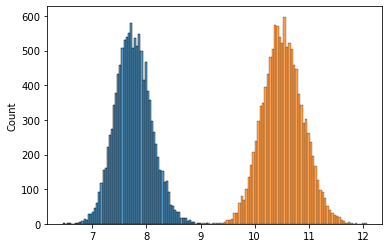

In [8]:
tr = trace_PL5.posterior.stack(draws=("chain", "draw"))

Control = np.mean(tr.bC[:,:].values, axis = 0)
PTSD    = np.mean(tr.bP[:,:].values, axis = 0)

sns.histplot(Control)
sns.histplot(PTSD)

Text(0.5, 1.0, '')

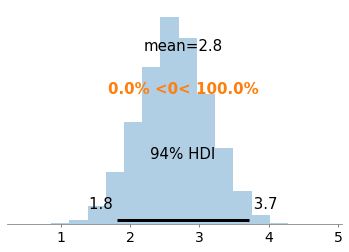

In [9]:
Group = PTSD - Control
az.plot_posterior(Group, point_estimate='mean', kind='hist', ref_val=0).set_title("")

The model overshoots a bit, but within the HDI.</br>
Let's look at the fit

<AxesSubplot:xlabel='x', ylabel='y'>

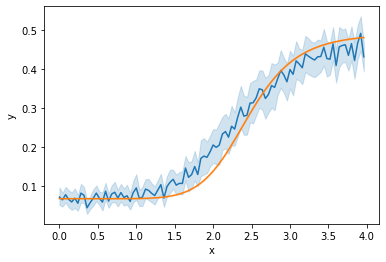

In [16]:
a5 = az.summary(trace_PL5, var_names=['aC'])[['mean']]
b5 = az.summary(trace_PL5, var_names=['bC'])[['mean']]
c5 = az.summary(trace_PL5, var_names=['cC'])[['mean']]
d5 = az.summary(trace_PL5, var_names=['dC'])[['mean']]
g5 = az.summary(trace_PL5, var_names=['gC'])[['mean']]

df_C = pd.DataFrame({'a': np.mean(a5['mean']),
                     'b': np.mean(b5['mean']),
                     'c': np.mean(c5['mean']),
                     'd': np.mean(d5['mean']),
                     'g': np.mean(g5['mean']),
                     'x': cont_df.x})

df_C['y'] = df_C.d + (df_C.a-df_C.d)/(1+(df_C.x/df_C.c)**df_C.b)**df_C.g


sns.lineplot(x='x',y='y',data=cont_df)
sns.lineplot(x='x',y='y',data=df_C)

<AxesSubplot:xlabel='x', ylabel='y'>

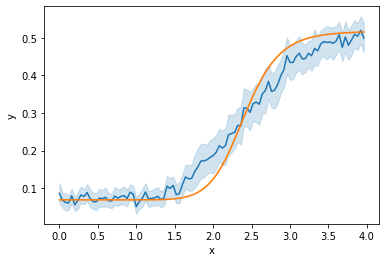

In [15]:
a5 = az.summary(trace_PL5, var_names=['aP'])[['mean']]
b5 = az.summary(trace_PL5, var_names=['bP'])[['mean']]
c5 = az.summary(trace_PL5, var_names=['cP'])[['mean']]
d5 = az.summary(trace_PL5, var_names=['dP'])[['mean']]
g5 = az.summary(trace_PL5, var_names=['gP'])[['mean']]

df_P = pd.DataFrame({'a': np.mean(a5['mean']),
                     'b': np.mean(b5['mean']),
                     'c': np.mean(c5['mean']),
                     'd': np.mean(d5['mean']),
                     'g': np.mean(g5['mean']),
                     'x': ptsd_df.x})

df_P['y'] = df_P.d + (df_P.a-df_P.d)/(1+(df_P.x/df_P.c)**df_P.b)**df_P.g

sns.lineplot(x='x',y='y',data=ptsd_df)
sns.lineplot(x='x',y='y',data=df_P)

Compare model to a linear model

In [10]:
with pm.Model() as linear:
    
    b_h = pm.Normal('b_h', 1, 1, shape=2)
   
    aC = pm.Normal('interceptC', 0, 5, shape = n_subs)
    bC = pm.Normal('slopeC', b_h[1], 1, shape = n_subs)
   
    aP = pm.Normal('interceptP', 0, 5, shape = n_subs)
    bP = pm.Normal('slopeP', b_h[0], 1, shape = n_subs)
    
    eps = pm.Exponential('eps', 1, shape=2)

    y_hatC = aC[sub_idxC] + bC[sub_idxC] * cont_df.x
    y_hatP = aP[sub_idxP] + bP[sub_idxP] * ptsd_df.x

       
    # Likelihood (sampling distribution) of observations
    ratingC = pm.Normal('ratingC',y_hatC, eps[0], observed=cont_df.y)
    ratingP = pm.Normal('ratingP',y_hatP, eps[1], observed=ptsd_df.y)

    
    trace_linear = pm.sample(3000, return_inferencedata=True, target_accept=0.95)

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_h, interceptC, slopeC, interceptP, slopeP, eps]
INFO:pymc:NUTS: [b_h, interceptC, slopeC, interceptP, slopeP, eps]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 124 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 124 seconds.


In [17]:
az.loo(trace_PL5, var_name="ratingP")

Computed from 12000 posterior samples and 5000 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  5055.47    53.11
p_loo      179.93        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     5000  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [18]:
az.loo(trace_linear, var_name="ratingP")

Computed from 12000 posterior samples and 5000 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  3631.34    48.56
p_loo       96.77        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     5000  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

The model fit looks very good.
To test for sensitivity let's try only 50 trials

In [41]:
n_subs = 100
slope_ptsd = 10
slope_control = 8
ptsd_df = pd.DataFrame()
cont_df = pd.DataFrame()
for i in range(n_subs):
    
    temp_p = add_sub(slope = slope_ptsd, trials = 30)
    temp_c = add_sub(slope = slope_control, trials = 30)
    temp_p['sub'] = i
    temp_c['sub'] = i
    ptsd_df = pd.concat([ptsd_df, temp_p])
    cont_df = pd.concat([cont_df, temp_c])
    
sub_idxP = list(ptsd_df['sub'])
sub_idxC = list(cont_df['sub'])

In [42]:
with pm.Model() as five_PL:
    
    # hyper prior per group
    b = pm.Normal('b', 6, 4, shape=2)
    
    aC = pm.Beta('aC',   1,   20,  shape = n_subs)
    bC = pm.Normal('bC', b[0], 2,  shape = n_subs)
    cC = pm.Normal('cC', 2.5, .5,  shape = n_subs)
    dC = pm.Beta('dC',   10,  10,  shape = n_subs)
    gC = pm.Normal('gC', 1,   .2,  shape = n_subs)
    
    aP = pm.Beta('aP',   1,   20,  shape = n_subs)
    bP = pm.Normal('bP', b[1], 2,  shape = n_subs)
    cP = pm.Normal('cP', 2.5, .5,  shape = n_subs)
    dP = pm.Beta('dP',   10,  10,  shape = n_subs)
    gP = pm.Normal('gP', 1,   .2,  shape = n_subs)
    
    
    eps = pm.Exponential('eps', 1, shape=2)
    
    y_hatC = dC[sub_idxC] + (aC[sub_idxC]-dC[sub_idxC])/(1+(cont_df['x'].values/cC[sub_idxC])**bC[sub_idxC])**gC[sub_idxC]
    y_hatP = dP[sub_idxP] + (aP[sub_idxP]-dP[sub_idxP])/(1+(ptsd_df['x'].values/cP[sub_idxP])**bP[sub_idxP])**gP[sub_idxP]

    # Likelihood (sampling distribution) of observations
    ratingC = pm.Normal('ratingC',y_hatC, eps[0], observed=cont_df.y)
    ratingP = pm.Normal('ratingP',y_hatP, eps[1], observed=ptsd_df.y)

    trace_PL5 = pm.sample(3000, return_inferencedata=True, target_accept=0.95)

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, aC, bC, cC, dC, gC, aP, bP, cP, dP, gP, eps]
INFO:pymc:NUTS: [b, aC, bC, cC, dC, gC, aP, bP, cP, dP, gP, eps]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 370 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 370 seconds.
There were 78 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc:There were 78 divergences after tuning. Increase `target_accept` or reparameterize.
There were 81 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc:There were 81 divergences after tuning. Increase `target_accept` or reparameterize.
There were 74 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc:There were 74 divergences after tuning. Increase `target_accept` or reparameterize.
There were 81 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc:There were 81 divergences after tuning. Increase `target_accept` or reparameterize.


<AxesSubplot:ylabel='Count'>

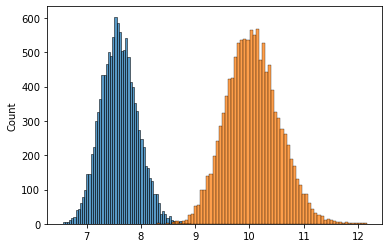

In [43]:
tr = trace_PL5.posterior.stack(draws=("chain", "draw"))

Control = np.mean(tr.bC[:,:].values, axis = 0)
PTSD    = np.mean(tr.bP[:,:].values, axis = 0)

sns.histplot(Control)
sns.histplot(PTSD)

Text(0.5, 1.0, '')

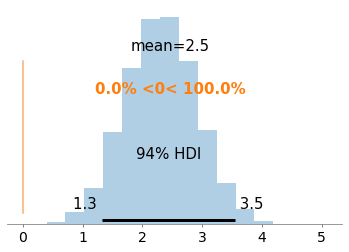

In [44]:
Group = PTSD - Control
az.plot_posterior(Group, point_estimate='mean', kind='hist', ref_val=0).set_title("")

Uneven data set?

In [48]:
n_subs_p = 50
n_subs_c = 450
slope_ptsd = 10
slope_control = 8
ptsd_df = pd.DataFrame()
cont_df = pd.DataFrame()
for i in range(n_subs_p):
    
    temp_p = add_sub(slope = slope_ptsd, trials = 40)
    temp_p['sub'] = i
    ptsd_df = pd.concat([ptsd_df, temp_p])

for i in range(n_subs_c):
    
    temp_c = add_sub(slope = slope_control, trials = 40)
    temp_c['sub'] = i
    cont_df = pd.concat([cont_df, temp_c])
    
sub_idxP = list(ptsd_df['sub'])
sub_idxC = list(cont_df['sub'])

In [49]:
with pm.Model() as five_PL:
    
    # hyper prior per group
    b = pm.Normal('b', 6, 4, shape=2)
    
    aC = pm.Beta('aC',   1,   20,  shape = n_subs_c)
    bC = pm.Normal('bC', b[0], 2,  shape = n_subs_c)
    cC = pm.Normal('cC', 2.5, .5,  shape = n_subs_c)
    dC = pm.Beta('dC',   10,  10,  shape = n_subs_c)
    gC = pm.Normal('gC', 1,   .2,  shape = n_subs_c)
    
    aP = pm.Beta('aP',   1,   20,  shape = n_subs_p)
    bP = pm.Normal('bP', b[1], 2,  shape = n_subs_p)
    cP = pm.Normal('cP', 2.5, .5,  shape = n_subs_p)
    dP = pm.Beta('dP',   10,  10,  shape = n_subs_p)
    gP = pm.Normal('gP', 1,   .2,  shape = n_subs_p)
    
    
    eps = pm.Exponential('eps', 1, shape=2)
    
    y_hatC = dC[sub_idxC] + (aC[sub_idxC]-dC[sub_idxC])/(1+(cont_df['x'].values/cC[sub_idxC])**bC[sub_idxC])**gC[sub_idxC]
    y_hatP = dP[sub_idxP] + (aP[sub_idxP]-dP[sub_idxP])/(1+(ptsd_df['x'].values/cP[sub_idxP])**bP[sub_idxP])**gP[sub_idxP]

    # Likelihood (sampling distribution) of observations
    ratingC = pm.Normal('ratingC',y_hatC, eps[0], observed=cont_df.y)
    ratingP = pm.Normal('ratingP',y_hatP, eps[1], observed=ptsd_df.y)

    trace_PL5 = pm.sample(3000, return_inferencedata=True, target_accept=0.95)

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, aC, bC, cC, dC, gC, aP, bP, cP, dP, gP, eps]
INFO:pymc:NUTS: [b, aC, bC, cC, dC, gC, aP, bP, cP, dP, gP, eps]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1377 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1377 seconds.
There were 1531 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc:There were 1531 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1790 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc:There were 1790 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8934, but should be close to 0.95. Try to increase the number of tuning steps.
There were 1492 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc:There were 1492 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1711 divergences after tuning. Increase `target_accept` or reparameterize.


<AxesSubplot:ylabel='Count'>

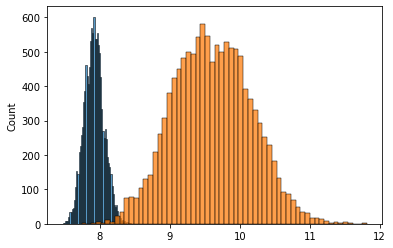

In [50]:
tr = trace_PL5.posterior.stack(draws=("chain", "draw"))

Control = np.mean(tr.bC[:,:].values, axis = 0)
PTSD    = np.mean(tr.bP[:,:].values, axis = 0)

sns.histplot(Control)
sns.histplot(PTSD)

Text(0.5, 1.0, '')

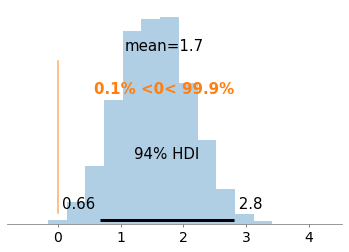

In [51]:
Group = PTSD - Control
az.plot_posterior(Group, point_estimate='mean', kind='hist', ref_val=0).set_title("")